simplify(k, node, fp, fd, ancestors):
* if k == 0 then return success
* If node is homothetic scaling of at least one ancestor, then return success
* candidate_facets <- node
* possible_labelings <- candidate_facets, fp
* valid_labelings = []
* for each labeling in possible_labelings:
  * feasible_rho <- labeling, fd
  * if feasible_rho not empty:
    * valid_labelings.add(labeling, rho)
* successes = []

* if valid_labelings not empty:
  * for each labeling, rho in valid_labelings:
    * for each facet in labeling:
      * simplify(k-1, facet, fp, fd)
    * successes.add(labeling, rho) if all facets succeed
* else if:  fp is d to d-k and k>1 # do reduction decomp
  * Reduction decomp steps weak --> strict boundaries
  * ...
  * ...
* else: # do splitting
  * Try to split at each vertex along fp or fd
    * aff <- vertex, f
    * L, R <- aff, node
    * If L and R both non-empty and same rank as node then proceed, else skip
    * L_lattice <- L
    * R_lattice <- R
    * L_ret = simplify(k, L_lattice.root, fp, fd)
    * R_ret = simplify(k, R_lattice.root, fp, fd)
    * If both L_ret & R_ret succeed:
    * successes.add(node, aff)
    * break
* return successes

In [1]:
%matplotlib notebook

from IPython.display import Image
from simplify.face_lattice import FaceLattice
from simplify.simplify import *
from simplify.plot import *
from islpy import *

In [2]:
s = Set("[N, M] -> { [i, j, k] : k >= -4 + i and k >= -4 + j and 0 <= k <= 8 and k <= j and k <= i }")
domain = Set("{ [i,j,k] : 0<=i,j<=12 and 0<=k<=8 }")

<IPython.core.display.Javascript object>


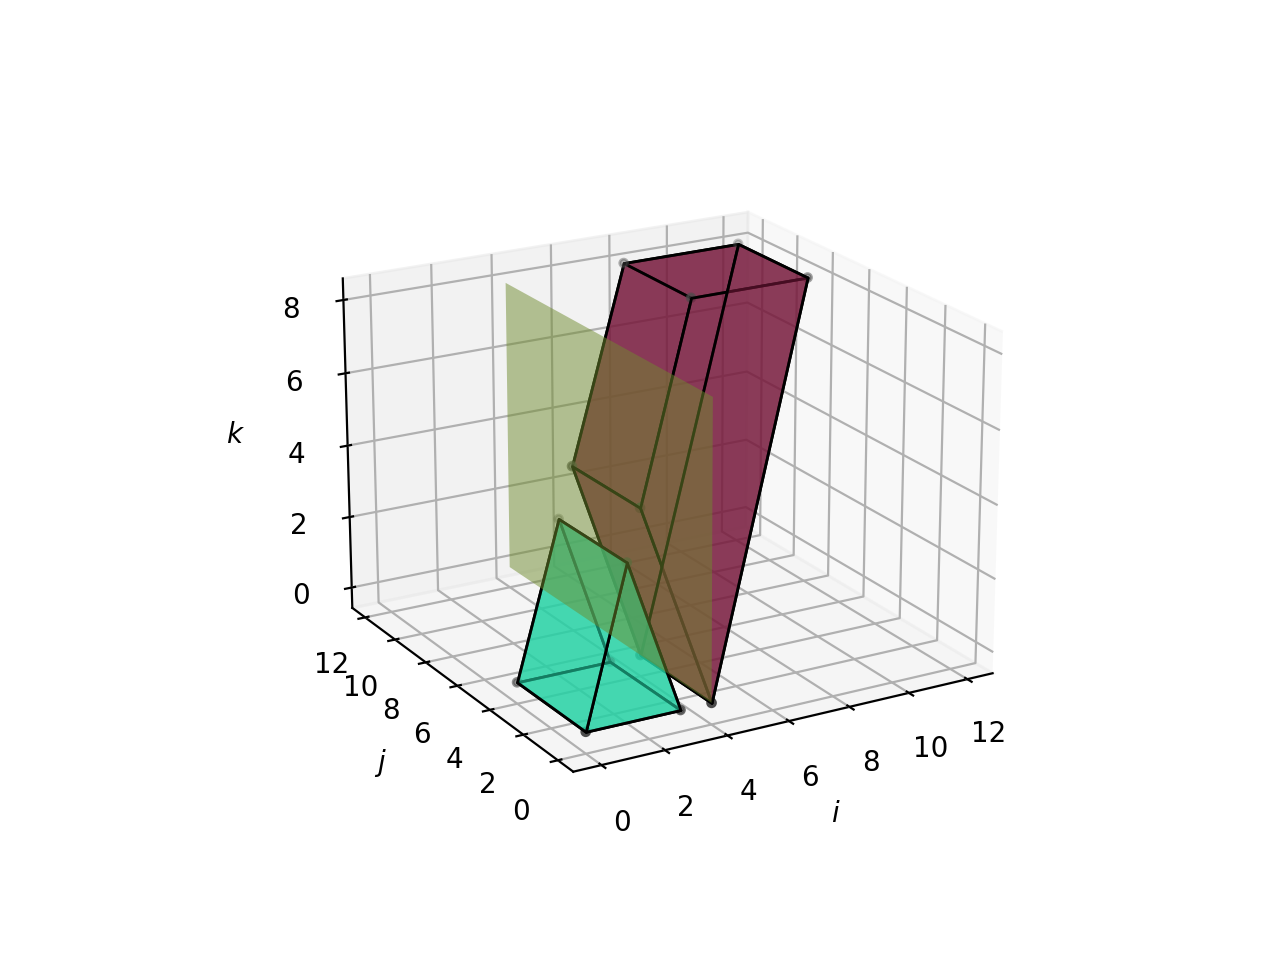

<Axes3DSubplot:xlabel='$i$', ylabel='$j$'>

In [3]:
l = Set("[N, M] -> { [i, j, k] : i <= 3 and k >= -4 + j and 0 <= k <= j and k <= i }")
r = Set("[N, M] -> { [i, j, k] : i >= 4 and k >= -4 + i and -4 + j <= k <= 8 and k <= j and k <= i }")
L = [l, r]
split = Set("{ [i,j,k] : i=4 }").intersect(domain)

plot_3d_sets(L, split=split)

Now let's look at the smaller piece, under the projection $f_{p} = {[i,j,k] \rightarrow [i]}$

<IPython.core.display.Javascript object>


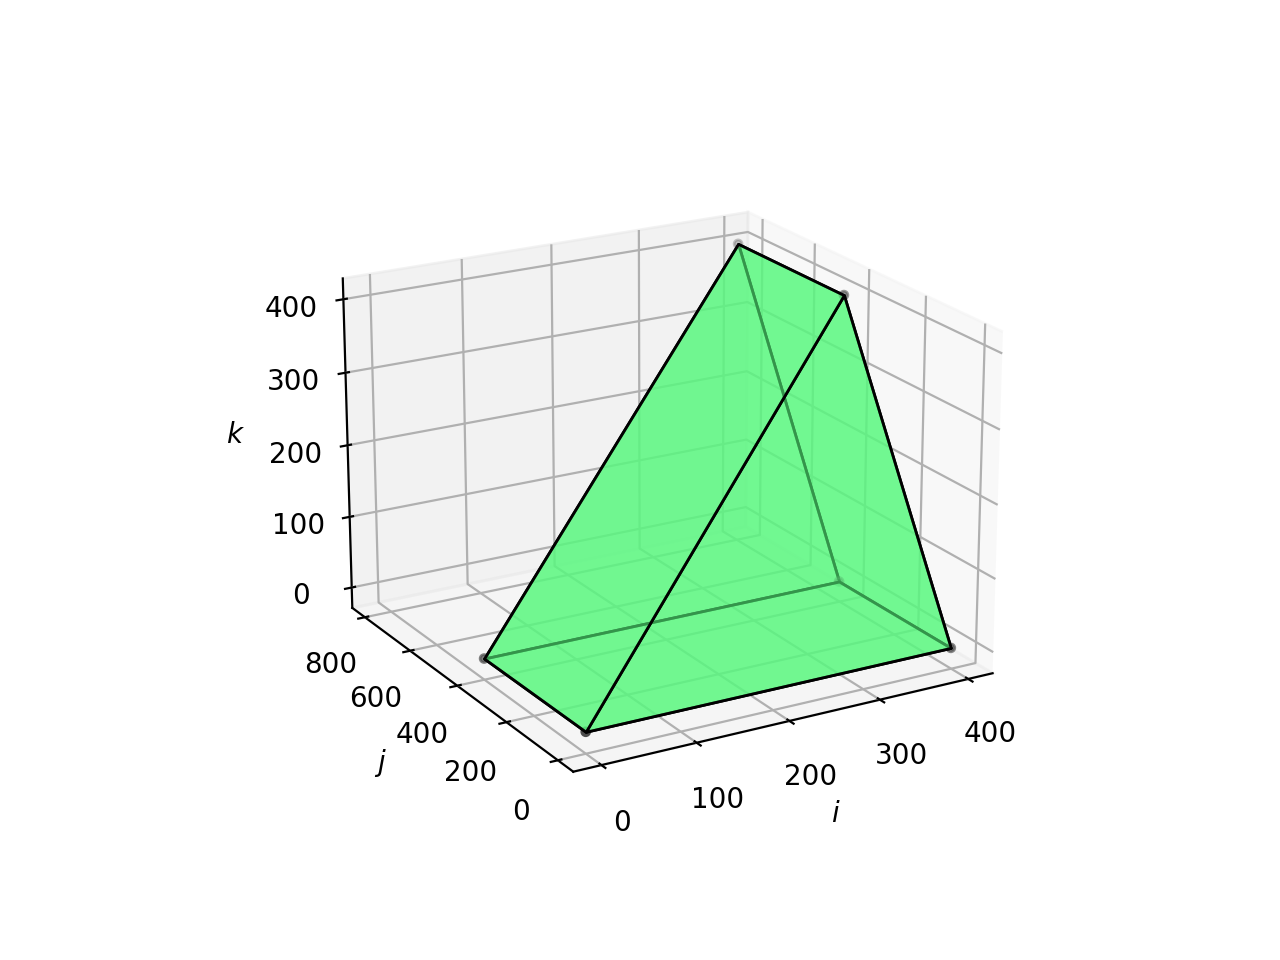

<Axes3DSubplot:xlabel='$i$', ylabel='$j$'>

In [2]:
node_bset = BasicSet('{ [i, j, k] : i <= 399 and k >= -400 + j and 0 <= k <= j and k <= i }')
plot_3d_sets([node_bset])

## Boundaries

Under a particular projection function $f_{p}$, each facet (the 2D faces in the picture above) are categorized as one of the following three:

**STRICT** boundary - all points in the facet contribute to the **same** answer:

$$\rm{ker}(f_{p}) \subseteq \rm{ker}(c)$$

**WEAK** boundary - some points (along at least one dimension) but not all contribute to the **same** answer:

$$ \rm{rank}(\rm{ker} (f_{p}) \cap \rm{ker}(c)) > 0$$

**NON** boundary - none of the points contribute to the same answer:

$$\rm{ker}(f_{p}) \not\subseteq \rm{ker}(c) \wedge \rm{rank}(\rm{ker}(f_{p}) \cap \rm{ker}(c)) = 0$$

Weak boundaries are a property in 3D spaces and higher. In 2D, a facet can only be a strict- or non-boundary.


*note*: $\subseteq$ should be read as "is a subset of"

### ker($f_{p}$)

Given $f_{p} = {[i,j,k] \rightarrow [i]}$, visually the null space of this projection is the $jk$-plane:

In [5]:
def plot_ker_3D_fp(fp_str):
    domain = BasicSet('{[i,j,k] : -20<=i,j,k<=20}')
    fl = FaceLattice('{[i,j,k] : 0<=i,j,k<=1}')
    fp = BasicMap(fp_str)
    ker_fp = fl.ker(fp).intersect(domain)
    plot_3d_sets([ker_fp])
    print('Here, ker_fp is {}-dimensional'.format(fl.compute_rank(ker_fp)))

<IPython.core.display.Javascript object>


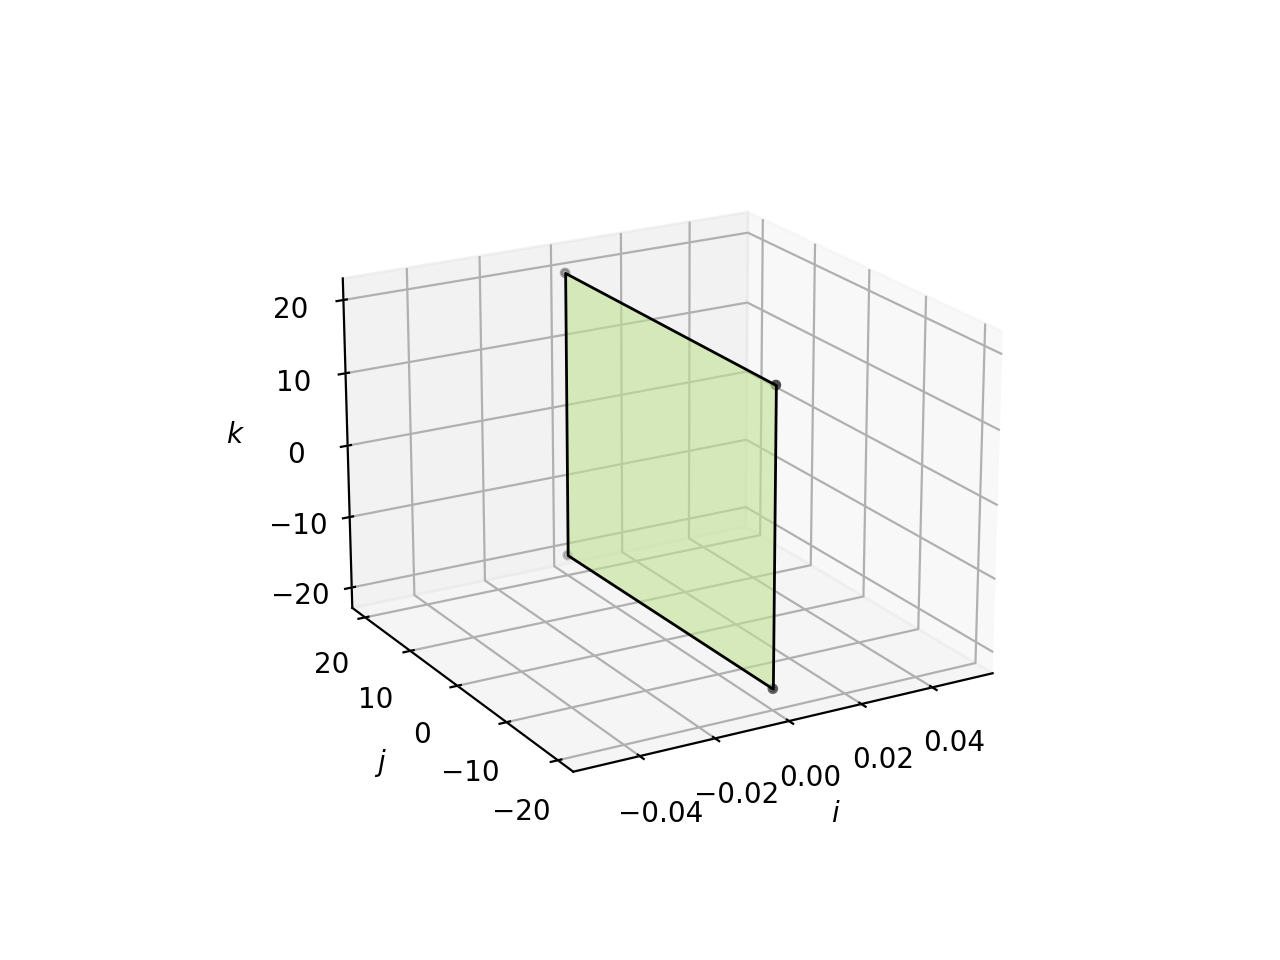

Here, ker_fp is 2-dimensional


In [6]:
plot_ker_3D_fp('{[i,j,k]->[i]}')

<IPython.core.display.Javascript object>


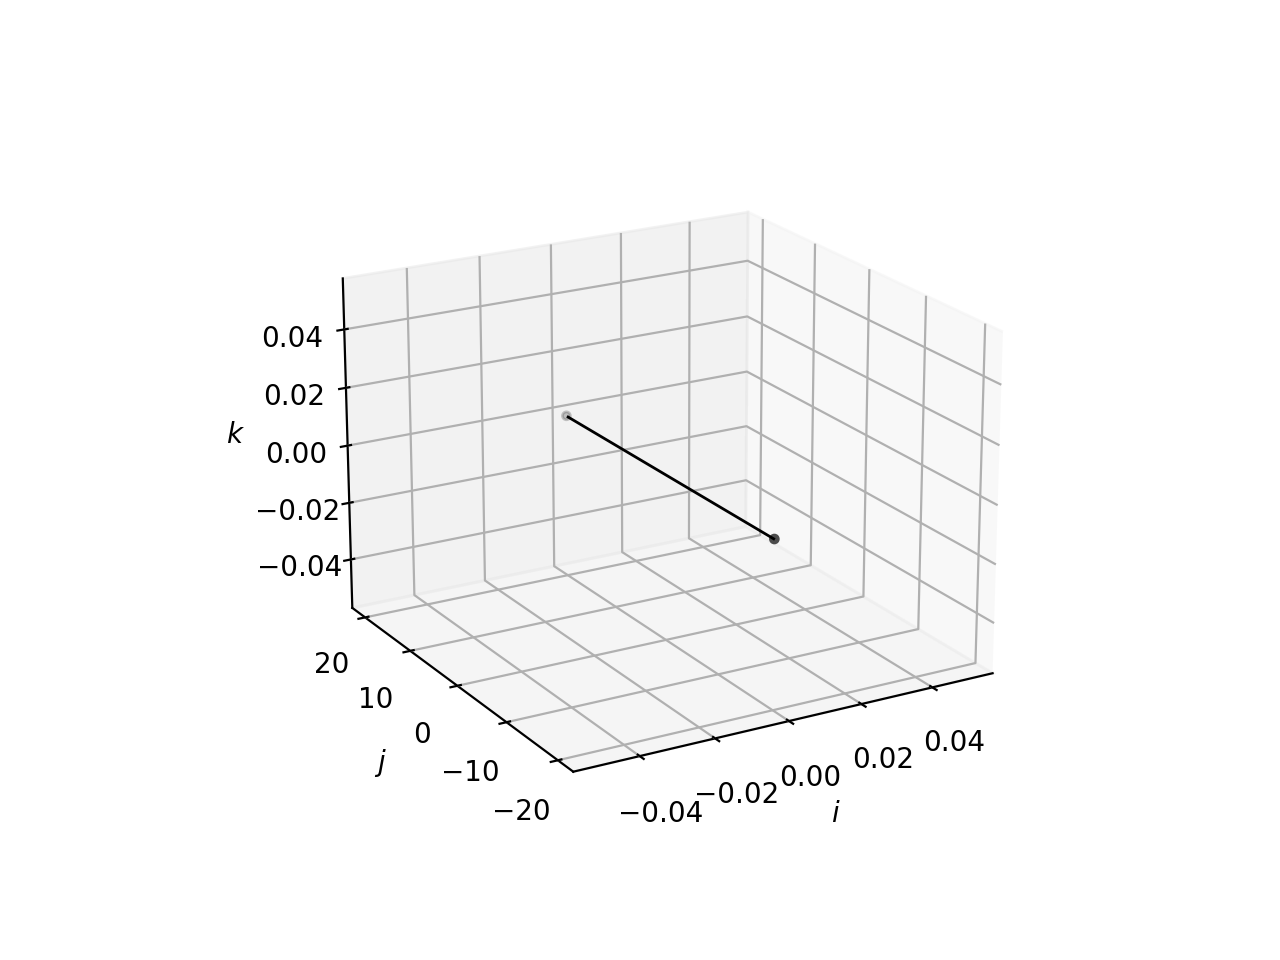

Here, ker_fp is 1-dimensional


In [7]:
plot_ker_3D_fp('{[i,j,k]->[i,k]}')

# Illustrative examples

The examples below illustrate what it means for a particular facet to be considered a boundary, and more specifically strict or weak. 

In [8]:
def illustrate_boundaries(s, fp_str, domain):
    node_bset = BasicSet(s)
    domain = BasicSet(domain)
    fp = BasicMap(fp_str)
    fl = FaceLattice(bset=node_bset)
    ker_fp = fl.ker(fp)
    node = fl.root[0]
    Lp = fl.get_Lp(node)
    for facet,c in zip(fl.get_facets(node), fl.isl_C):
        print(set(facet), c)
        print('fp = {}'.format(fp_str))
        print('ker_fp = {}'.format(ker_fp))
        facet_Lp = fl.get_Lp(facet)
        print('facet_Lp = {}'.format(facet_Lp))
        print(fl.boundary_label(facet, fp, Lp))
        contribute_to_same_answer = facet_Lp.intersect(ker_fp).intersect(domain)
        ax = plot_3d_sets([ker_fp.intersect(domain), facet_Lp.intersect(domain)], alpha=0.3)
        plot_bset_3d_points(ax, contribute_to_same_answer, True, 'r', 20)
        print()

### Scenario A: 3D node, 2D ker(fp)

<IPython.core.display.Javascript object>


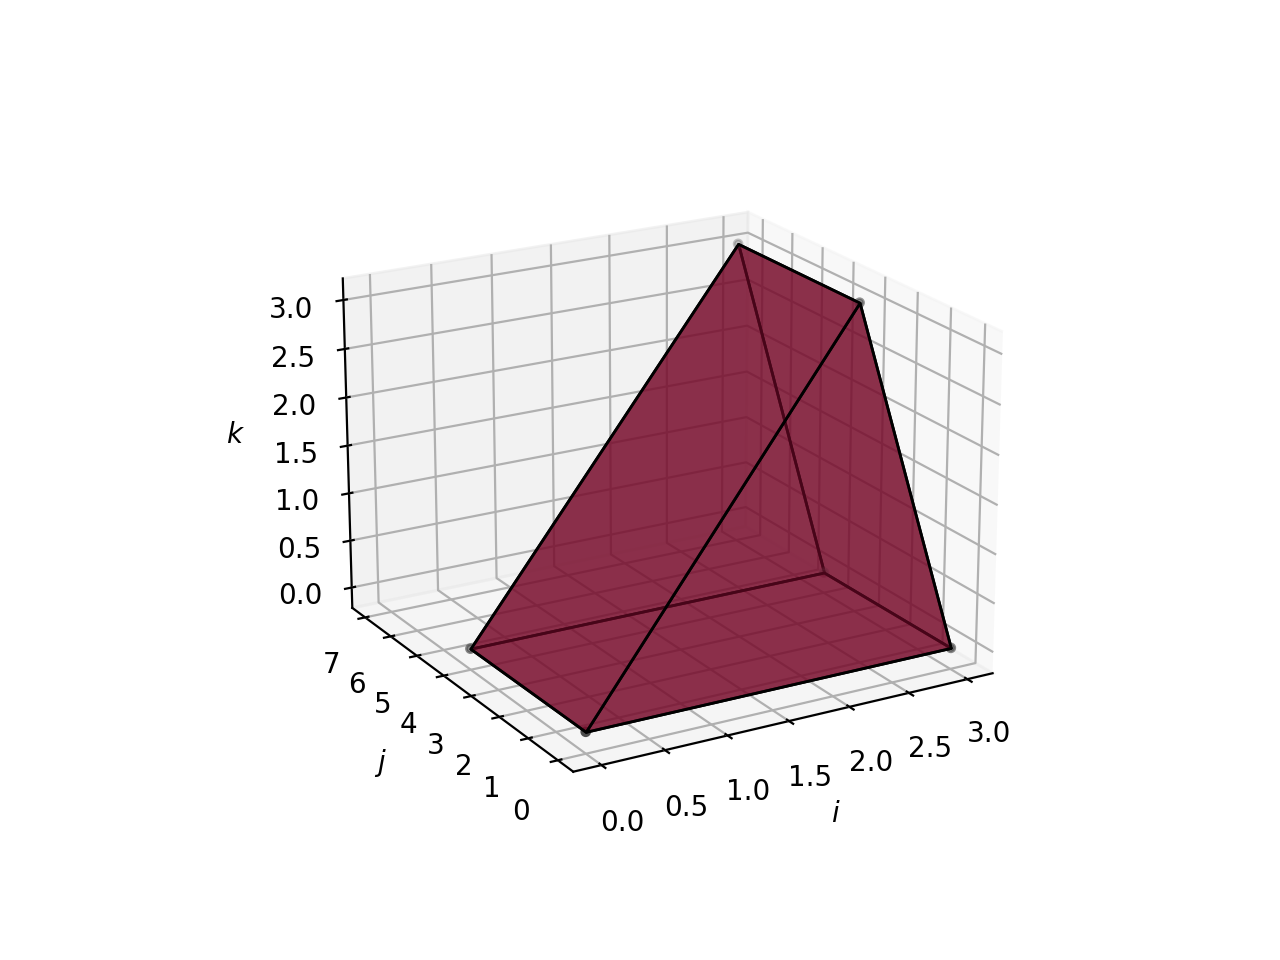


c0	[[-1  0  0  3]	{ [i, j, k] : 3 - i >= 0 }
c1	 [ 0 -1  1  4]	{ [i, j, k] : 4 - j + k >= 0 }
c2	 [ 0  0  1  0]	{ [i, j, k] : k >= 0 }
c3	 [ 0  1 -1  0]	{ [i, j, k] : j - k >= 0 }
c4	 [ 1  0 -1  0]]	{ [i, j, k] : i - k >= 0 }

{4} { [i, j, k] : 3 - i >= 0 }
fp = {[i,j,k]->[i]}
ker_fp = { [i, j, k] : i = 0 }
facet_Lp = { [i, j, k] : k = i }
BoundaryLabel.WEAK_BOUNDARY


<IPython.core.display.Javascript object>


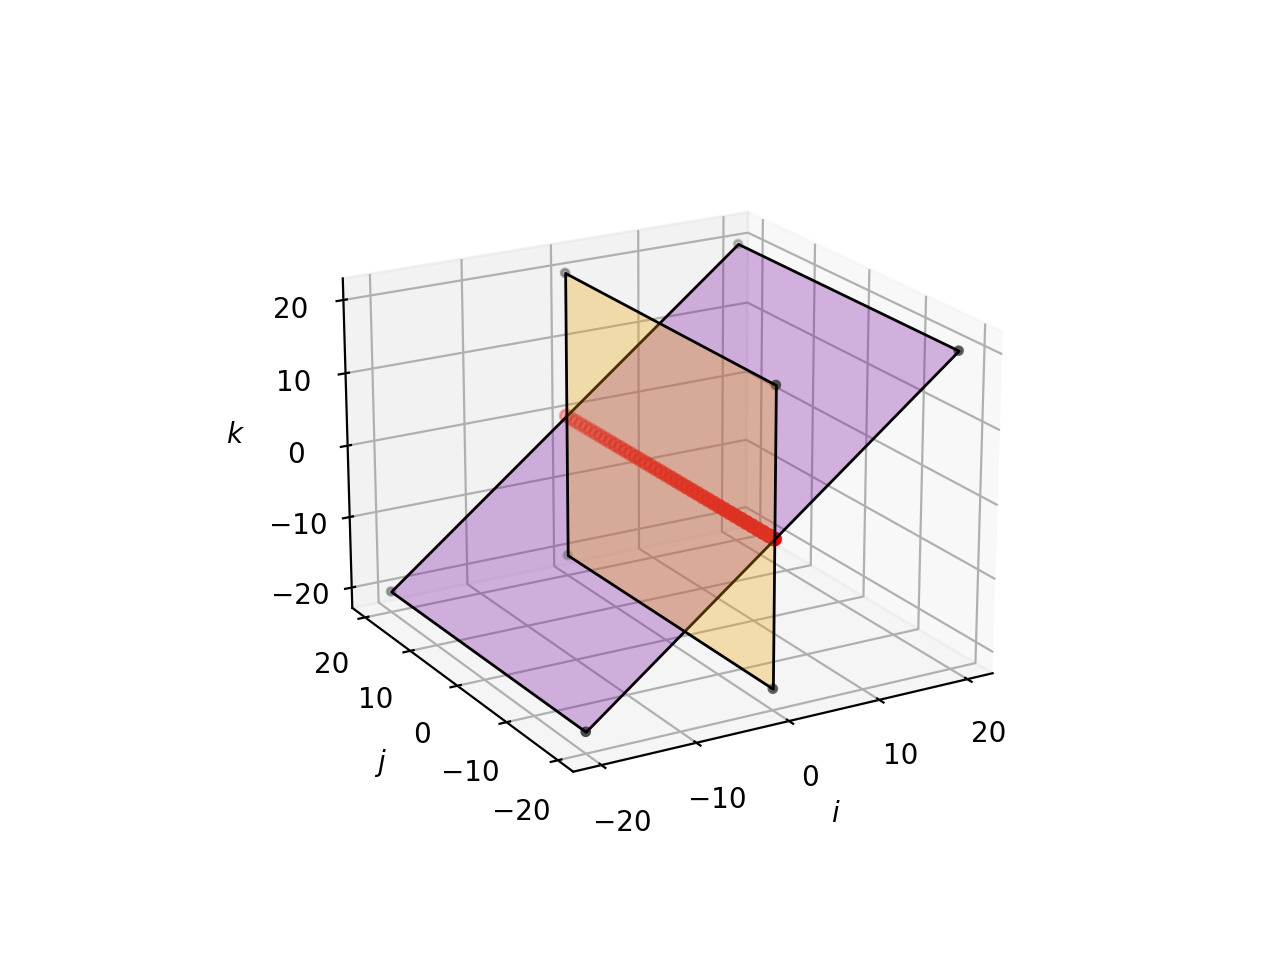


{3} { [i, j, k] : 4 - j + k >= 0 }
fp = {[i,j,k]->[i]}
ker_fp = { [i, j, k] : i = 0 }
facet_Lp = { [i, j, k] : k = j }
BoundaryLabel.WEAK_BOUNDARY


<IPython.core.display.Javascript object>


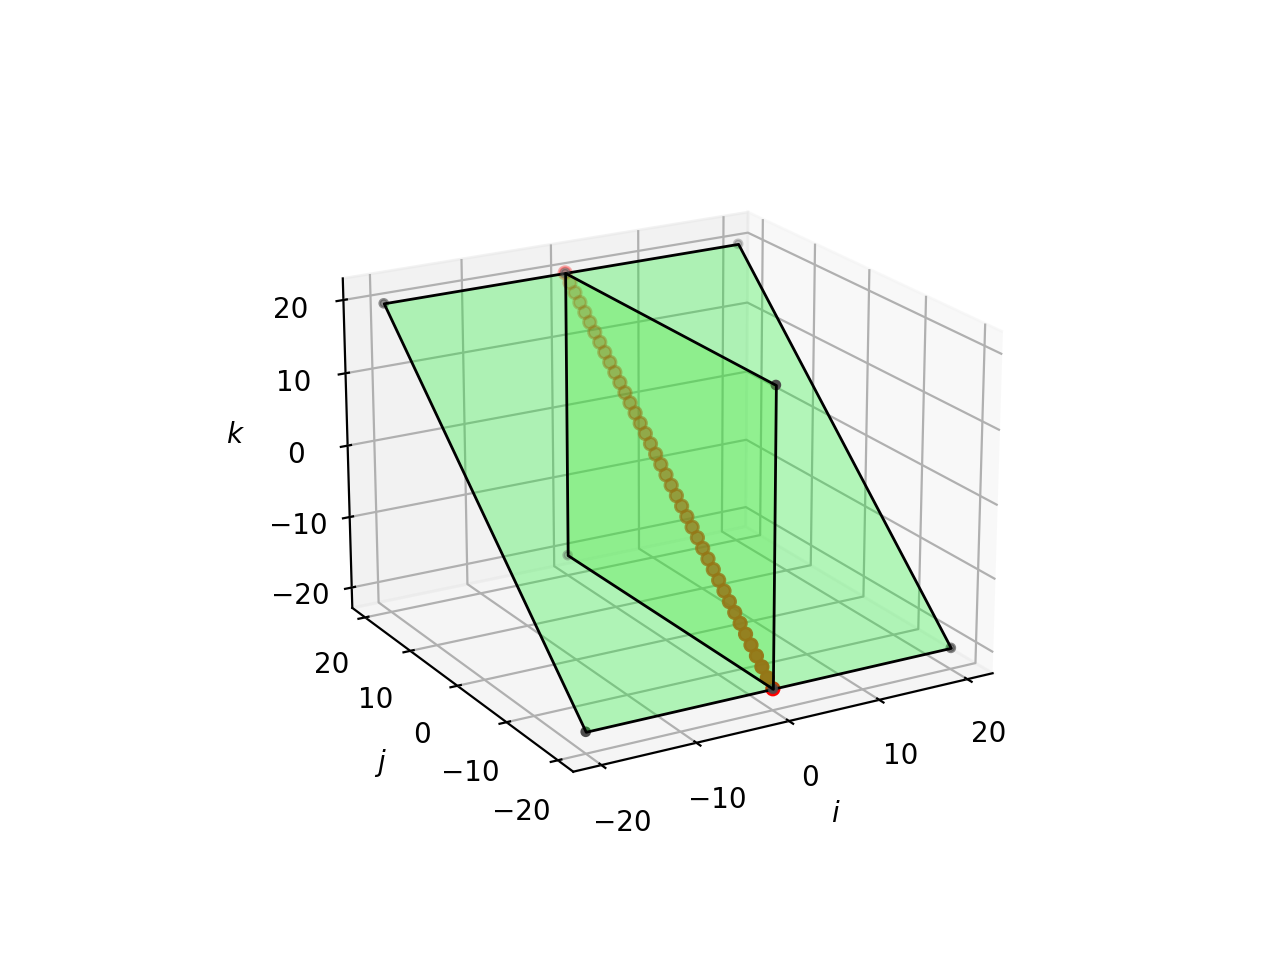


{2} { [i, j, k] : k >= 0 }
fp = {[i,j,k]->[i]}
ker_fp = { [i, j, k] : i = 0 }
facet_Lp = { [i, j, k] : k = 0 }
BoundaryLabel.WEAK_BOUNDARY


<IPython.core.display.Javascript object>


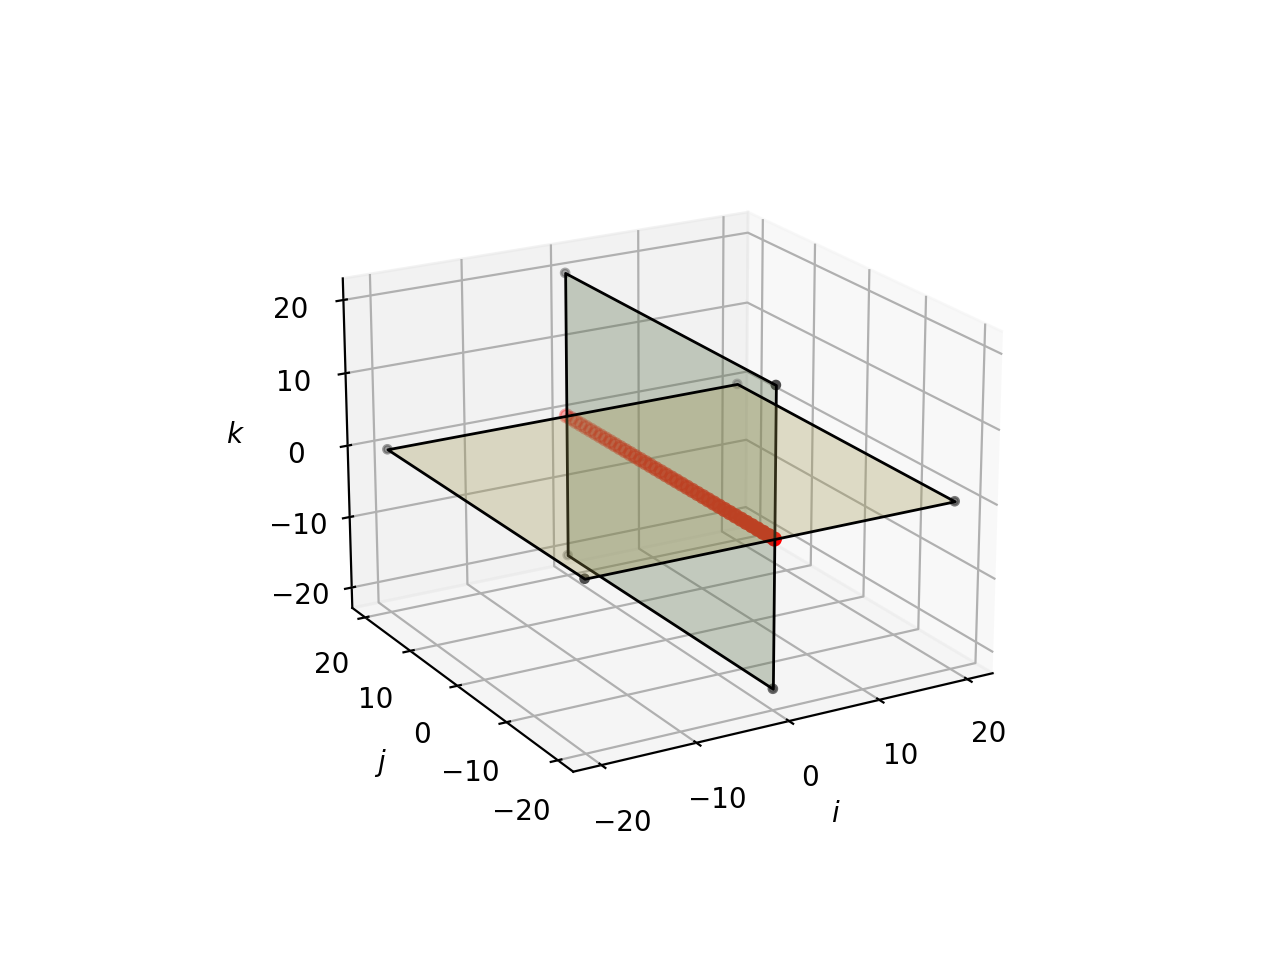


{1} { [i, j, k] : j - k >= 0 }
fp = {[i,j,k]->[i]}
ker_fp = { [i, j, k] : i = 0 }
facet_Lp = { [i, j, k] : k = j }
BoundaryLabel.WEAK_BOUNDARY


<IPython.core.display.Javascript object>


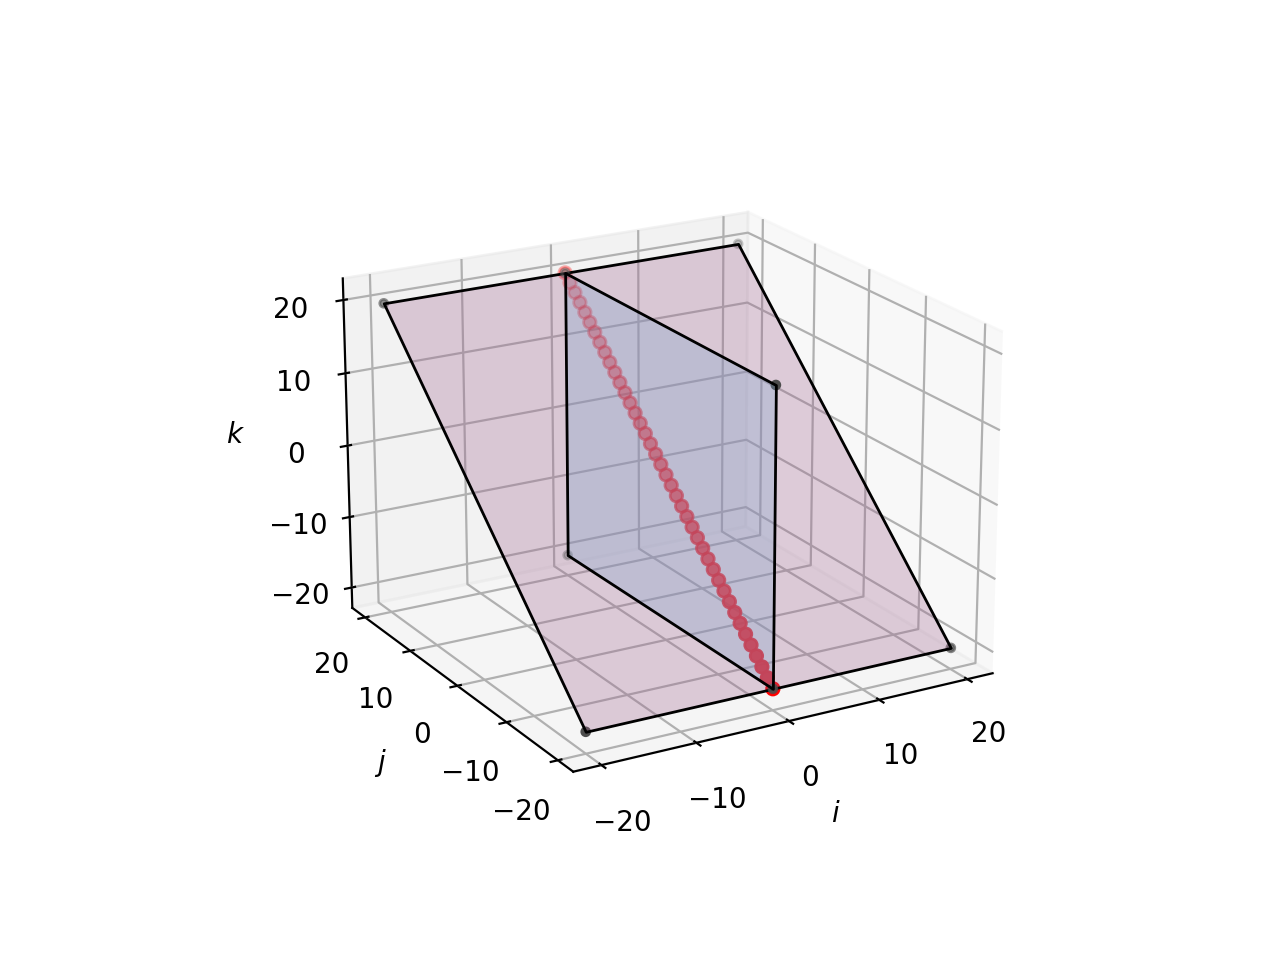


{0} { [i, j, k] : i - k >= 0 }
fp = {[i,j,k]->[i]}
ker_fp = { [i, j, k] : i = 0 }
facet_Lp = { [i, j, k] : i = 0 }
BoundaryLabel.STRICT_BOUNDARY


<IPython.core.display.Javascript object>


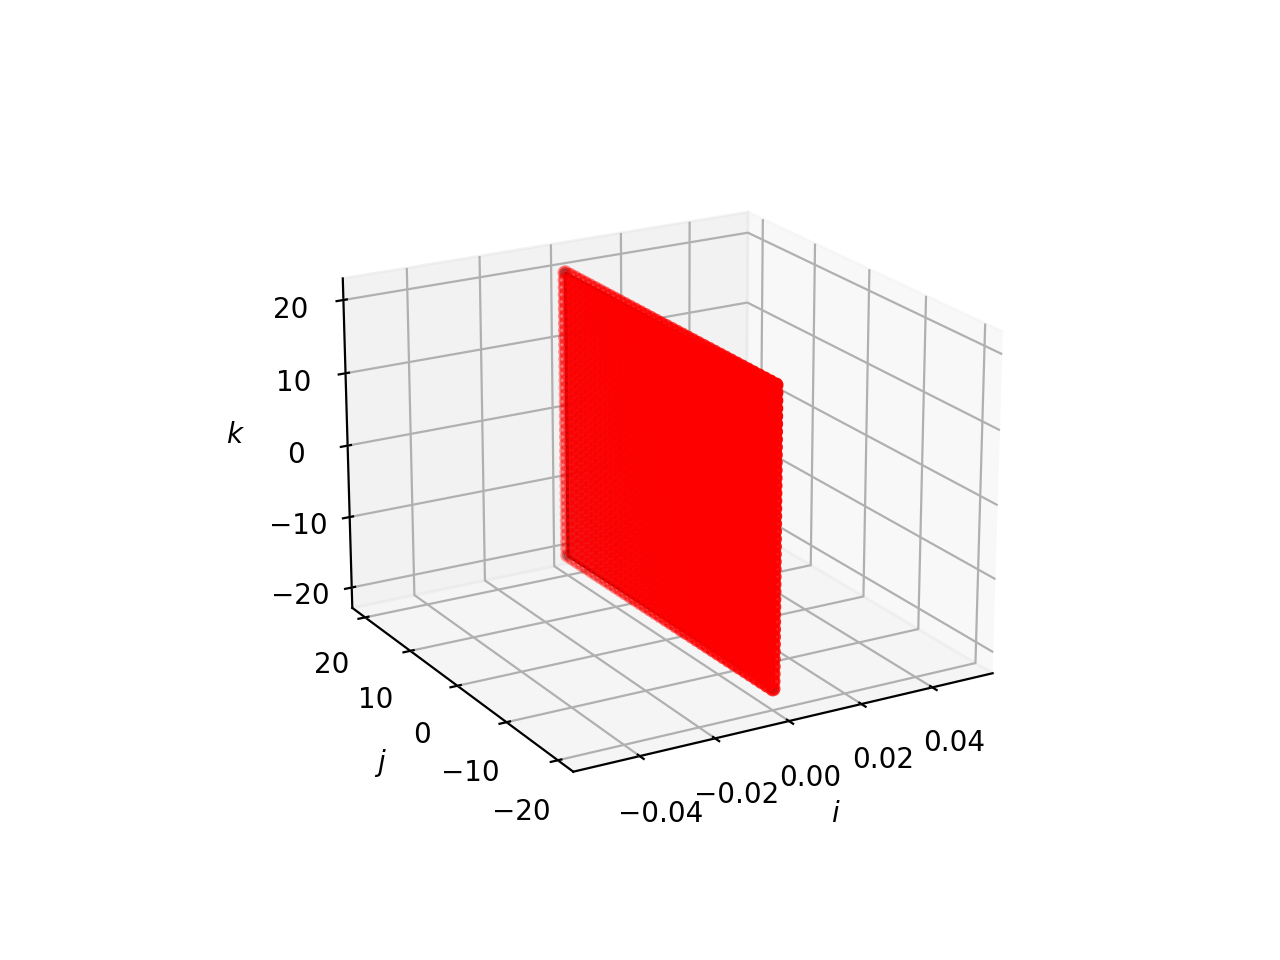

In [18]:
# consider a 3D node
s = '{ [i, j, k] : i <= 3 and k >= -4 + j and 0 <= k <= j and k <= i }'

# and projection fp with 2D kernel
fp = '{[i,j,k]->[i]}'

plot_3d_sets([BasicSet(s)])
print()
fl = FaceLattice(s)
fl.pretty_print_constraints()
illustrate_boundaries(s, fp, '{[i,j,k] : -20<=i,j,k<=20}')

### Scenario B: 3D node, 1D ker(fp)

<IPython.core.display.Javascript object>


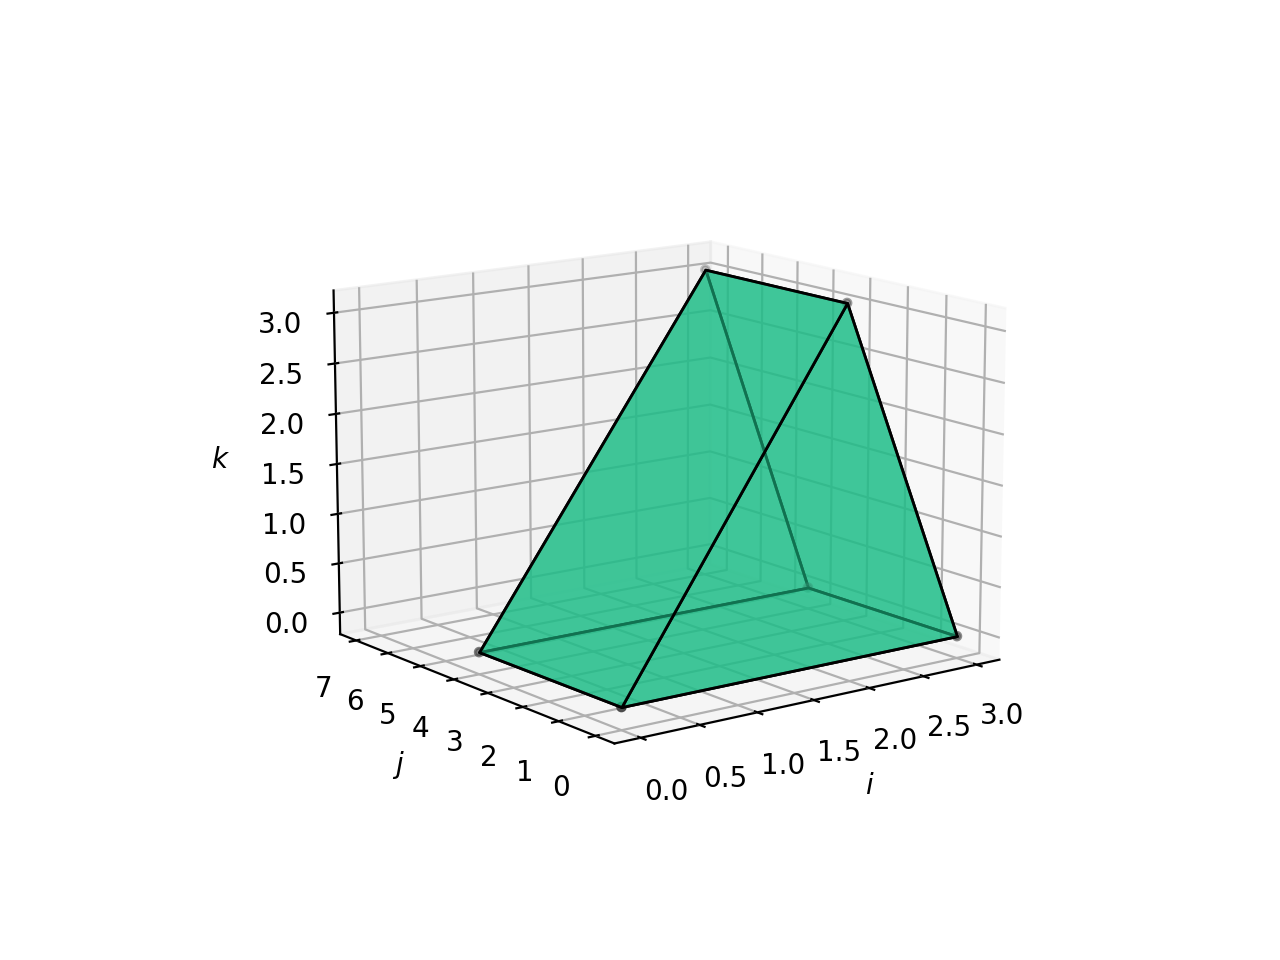


{4} { [i, j, k] : 3 - i >= 0 }
fp = {[i,j,k]->[i,j]}
ker_fp = { [i, j, k] : i = 0 and j = 0 }
facet_Lp = { [i, j, k] : k = i }
BoundaryLabel.NON_BOUNDARY


<IPython.core.display.Javascript object>


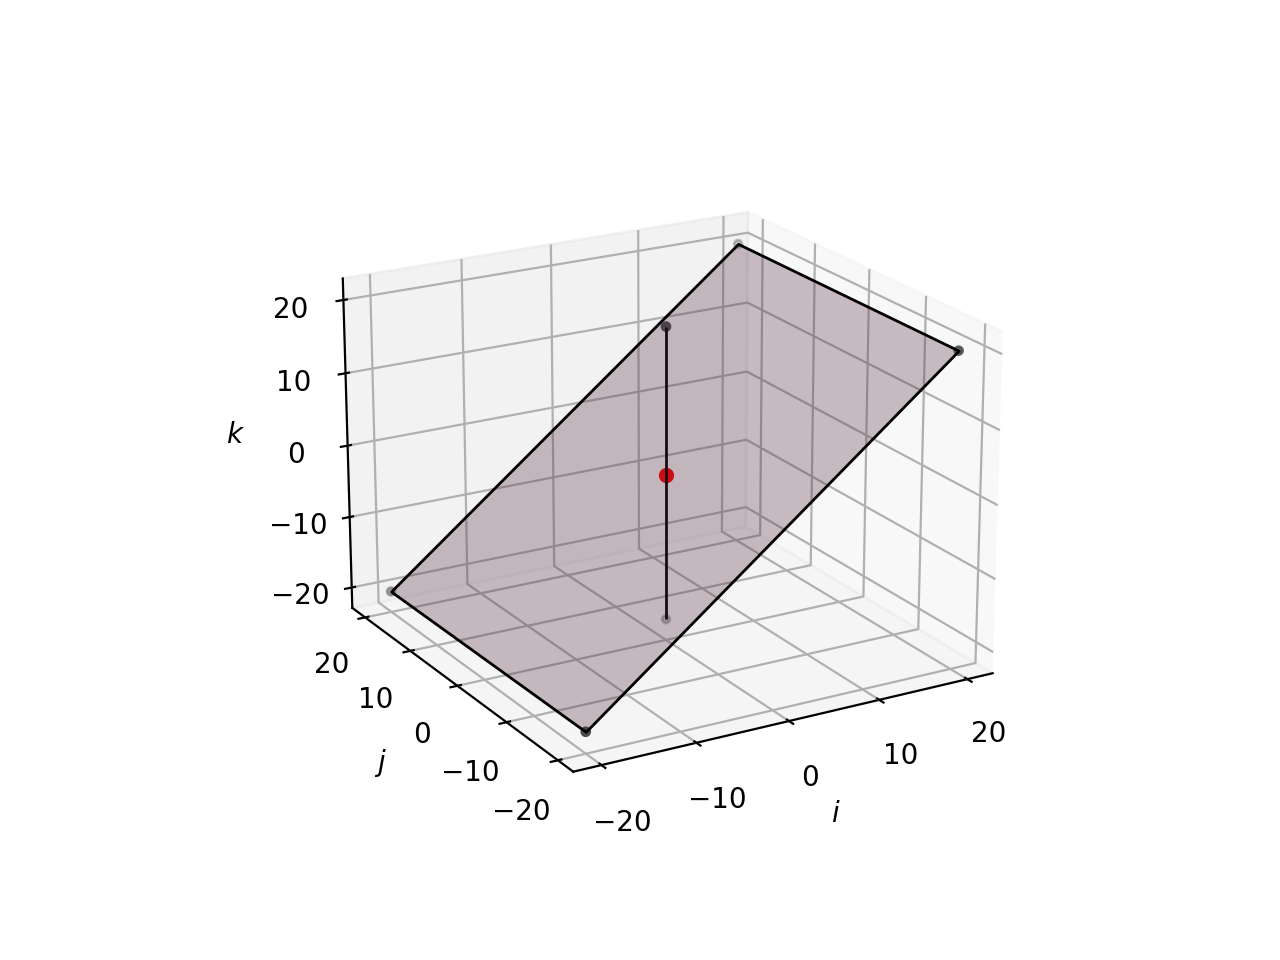


{3} { [i, j, k] : 4 - j + k >= 0 }
fp = {[i,j,k]->[i,j]}
ker_fp = { [i, j, k] : i = 0 and j = 0 }
facet_Lp = { [i, j, k] : k = j }
BoundaryLabel.NON_BOUNDARY


<IPython.core.display.Javascript object>


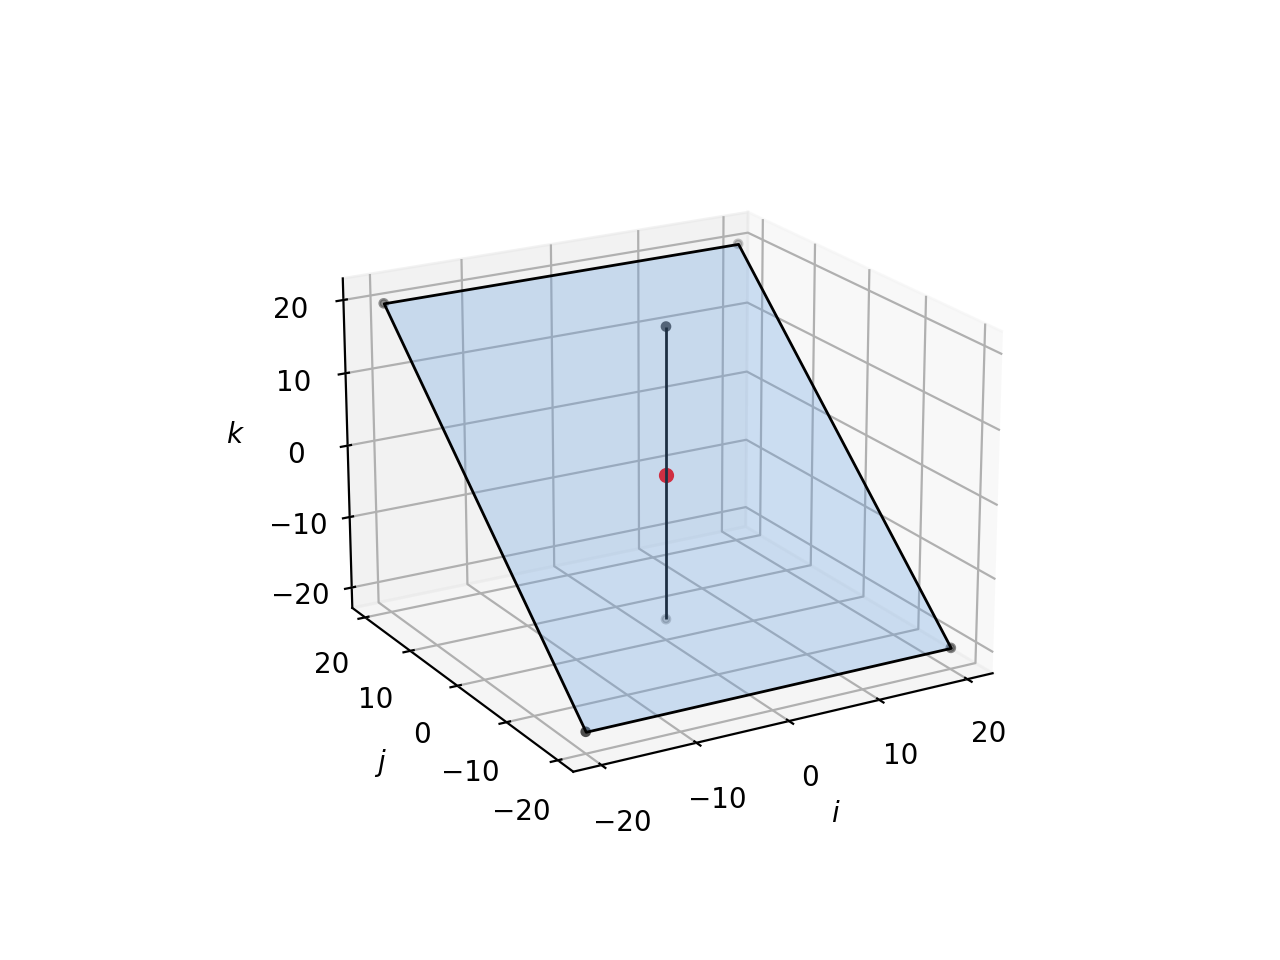


{2} { [i, j, k] : k >= 0 }
fp = {[i,j,k]->[i,j]}
ker_fp = { [i, j, k] : i = 0 and j = 0 }
facet_Lp = { [i, j, k] : k = 0 }
BoundaryLabel.NON_BOUNDARY


<IPython.core.display.Javascript object>


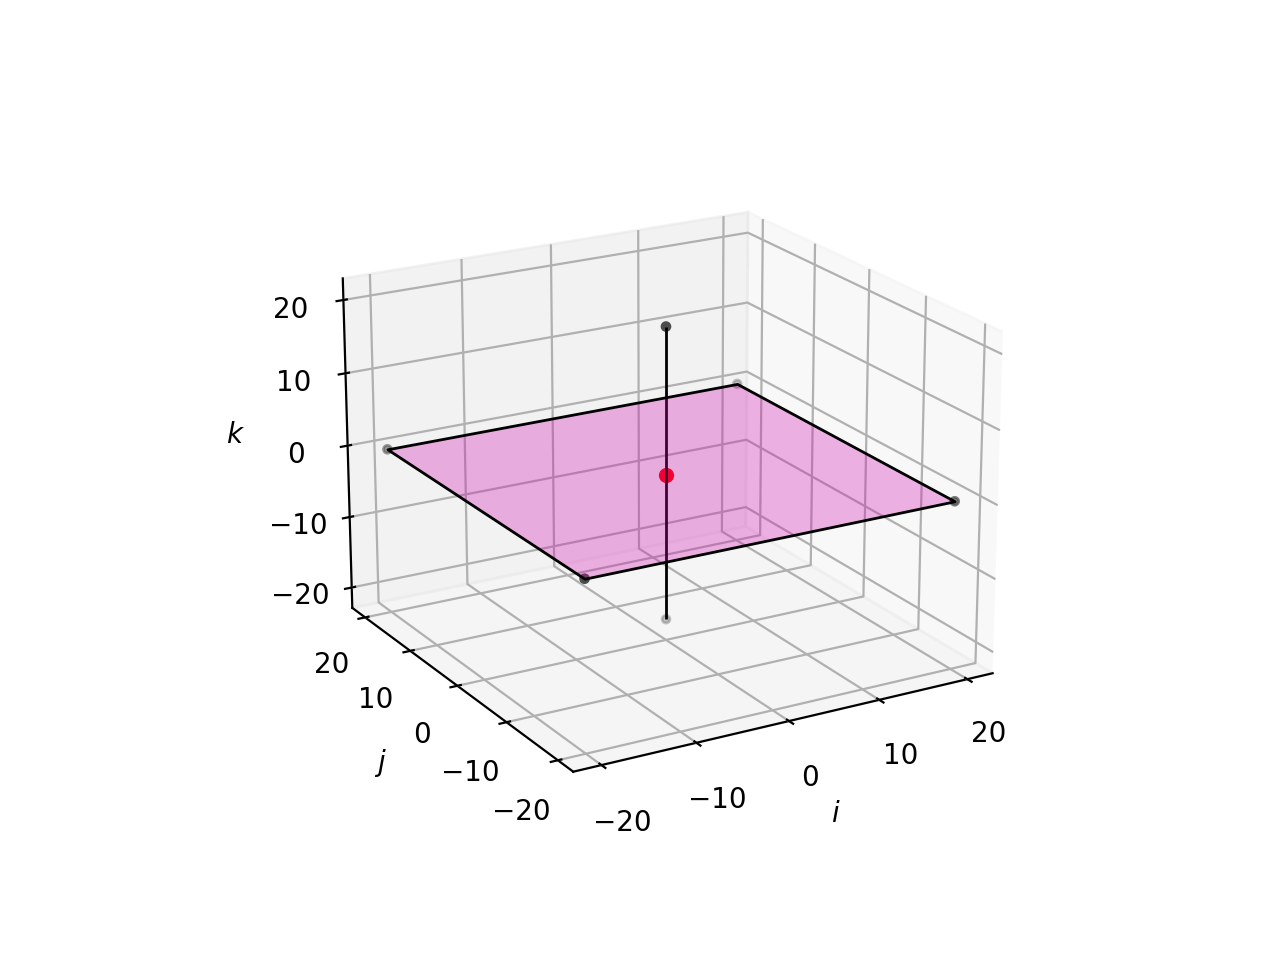


{1} { [i, j, k] : j - k >= 0 }
fp = {[i,j,k]->[i,j]}
ker_fp = { [i, j, k] : i = 0 and j = 0 }
facet_Lp = { [i, j, k] : k = j }
BoundaryLabel.NON_BOUNDARY


<IPython.core.display.Javascript object>


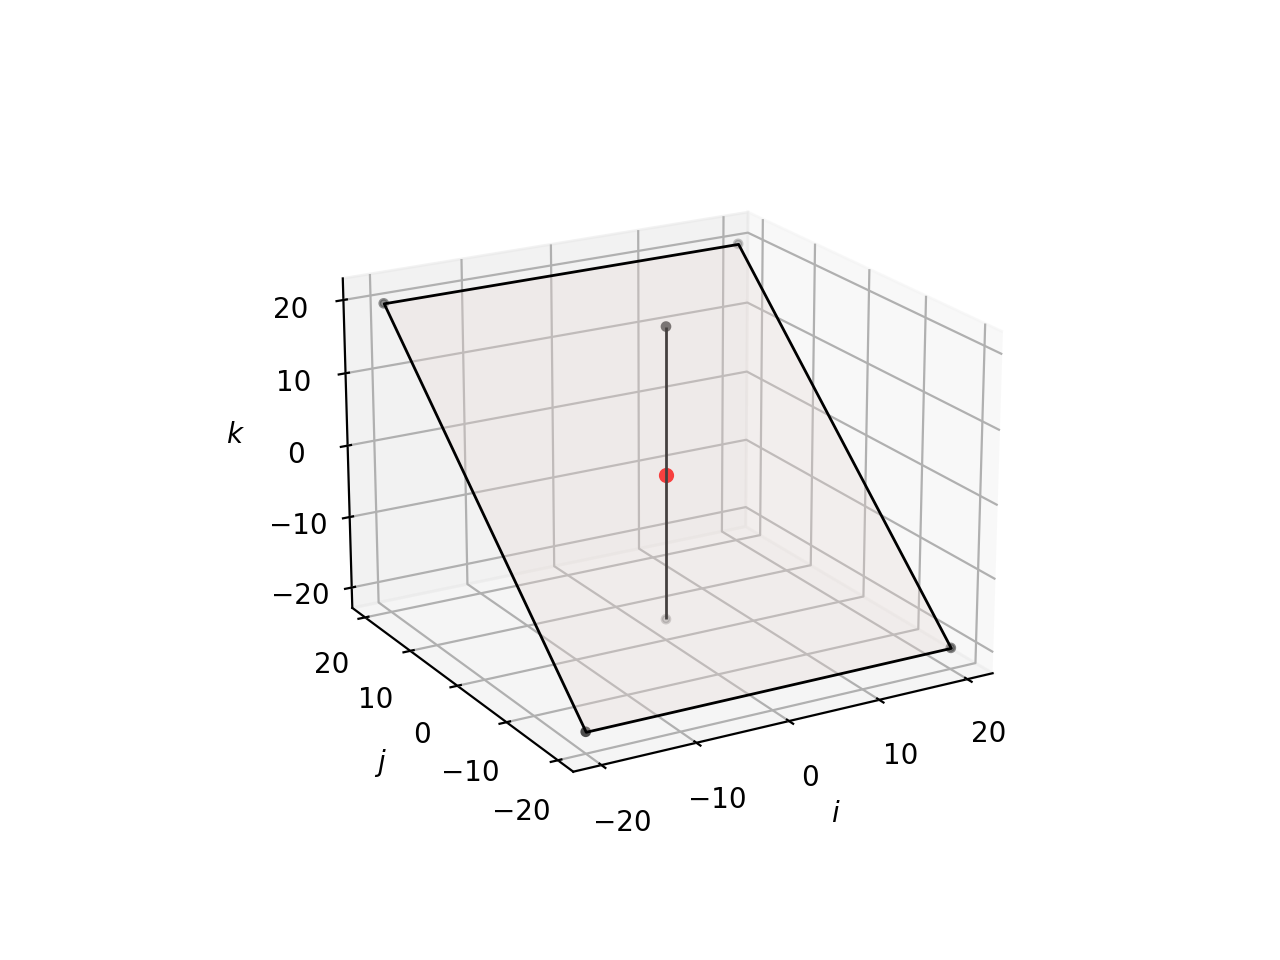


{0} { [i, j, k] : i - k >= 0 }
fp = {[i,j,k]->[i,j]}
ker_fp = { [i, j, k] : i = 0 and j = 0 }
facet_Lp = { [i, j, k] : i = 0 }
BoundaryLabel.STRICT_BOUNDARY


<IPython.core.display.Javascript object>


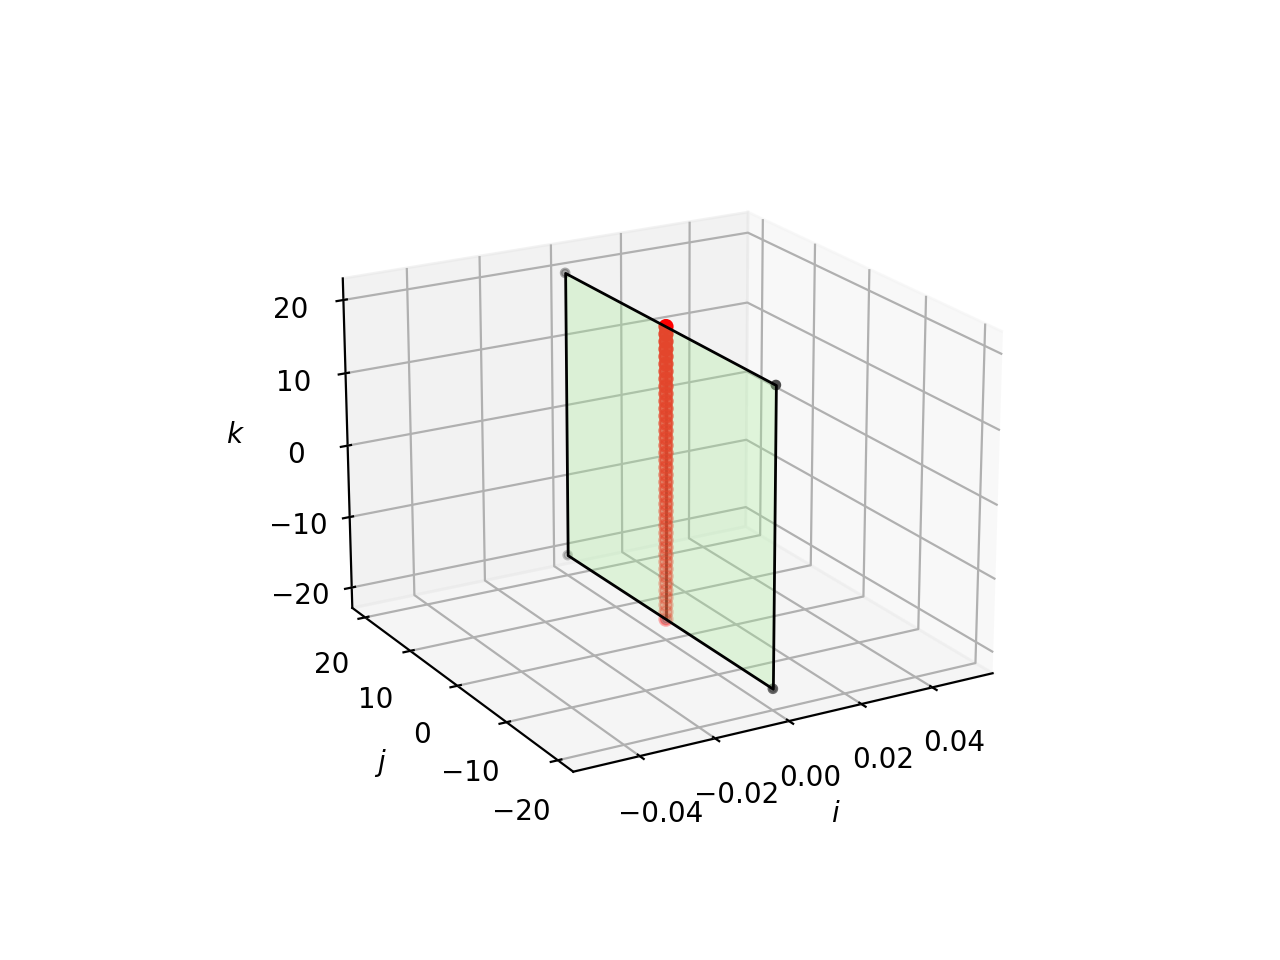

In [16]:
# consider a 3D node
s = '{ [i, j, k] : i <= 3 and k >= -4 + j and 0 <= k <= j and k <= i }'

# and projection fp with 1D kernel
fp = '{[i,j,k]->[i,j]}'

plot_3d_sets([BasicSet(s)])
print()

illustrate_boundaries(s, fp, '{[i,j,k] : -20<=i,j,k<=20}')

### Scenario C: 2D node, 2D ker(fp)

<IPython.core.display.Javascript object>


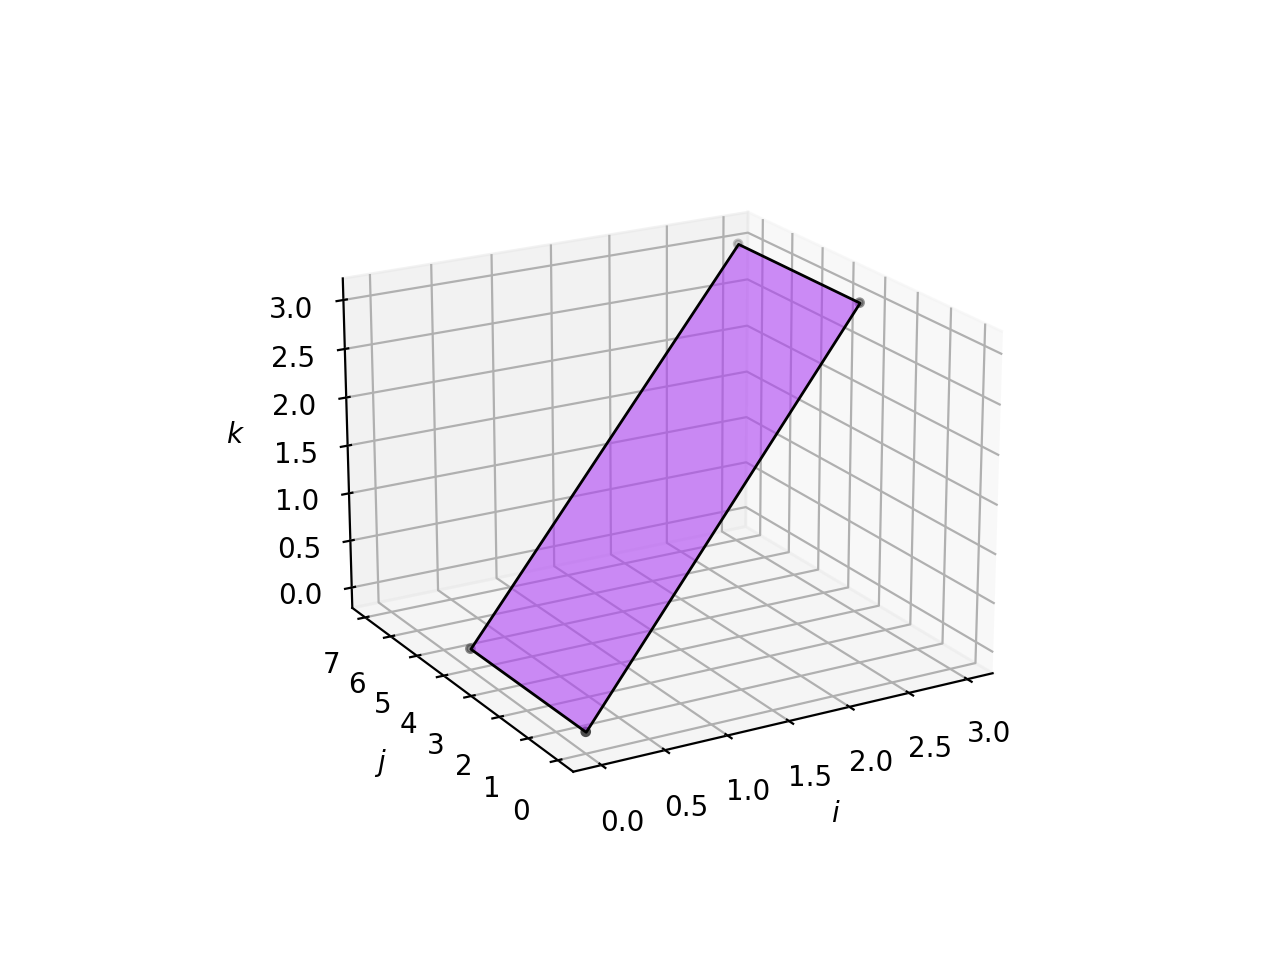

In [11]:
# consider a 2D node embedded in 3D space
s = '{[i,j,k] : i<=3 and k>=-4+j and 0<=k<=j and k=i }'

# and projection fp with 2D kernel
fp = '{[i,j,k]->[i]}'

plot_3d_sets([BasicSet(s)])
print()

#illustrate_boundaries(s, fp, '{[i,j,k] : -20<=i,j,k<=20}')

### Scenario D: 2D node, 1D ker(fp)

<IPython.core.display.Javascript object>


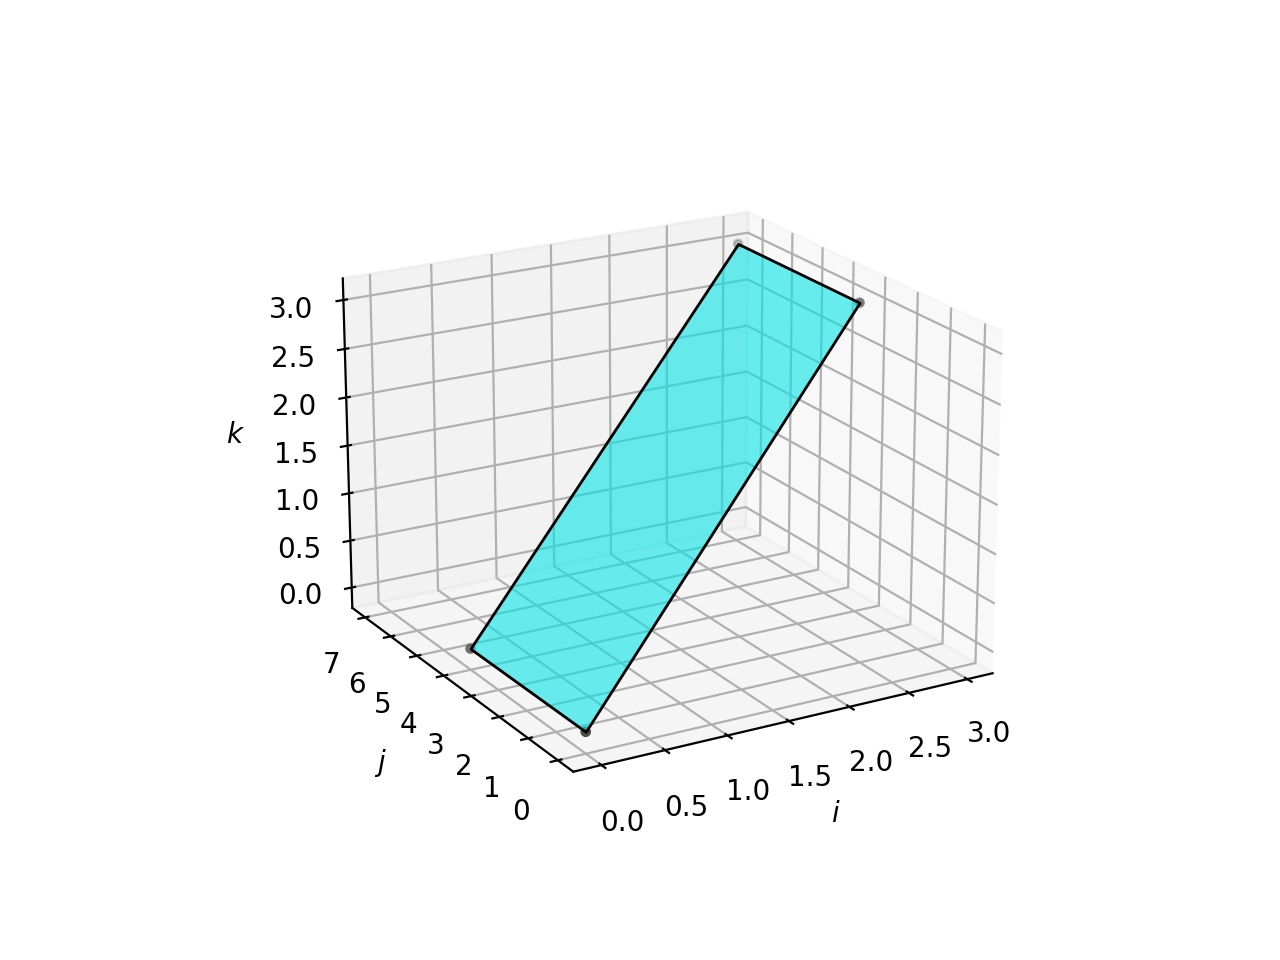

In [12]:
# consider a 2D node embedded in 3D space
s = '{[i,j,k] : i<=3 and k>=-4+j and 0<=k<=j and k=i }'

# and projection fp with 1D kernel
fp = '{[i,j,k]->[i,j]}'

plot_3d_sets([BasicSet(s)])
print()

#illustrate_boundaries(s, fp, '{[i,j,k] : -20<=i,j,k<=20}')

## Reduction Decomposition

We can always transform a weak boundary into a strict boundary by decomposing the projection function. Weak boundaries only manifest when both $ker(f_{p})$ and the linear space of the facet in question, $L_{p}$, are of rank greater than 2 (i.e., higher than 2D).

In [13]:
def construct_rho_for_all_labelings(lattice, fp, fd, legal_labels=['ADD','INV']):
    node = lattice.root[0]
    Lp = fl.get_Lp(node)
    candidate_facets = lattice.get_candidate_facets(node, fp)
    # faces, parent, Lp, lattice, labels, fd
    label_combos = list()
    header = ['{}'.format(set(f)) for f in candidate_facets]
    print(header)
    print('-' * len(str(header)))
    for labels in enumerate_labels(candidate_facets, legal_labels):
        rho, satisfied_facets, problem_facet = rho_from_labels(candidate_facets, node, Lp, lattice, labels, fd)
        if rho:
            label_combos.append(labels + [rho])
            print('{}  possible -> rho = {}'.format(labels, rho))
        else:
            print('{}  impossible'.format(labels))
    print()
    
def make_all_decompositions(lattice, fp_str, fp):
    node = lattice.root[0]
    Lp = lattice.get_Lp(node)
    weak_boundaries = lattice.get_weak_boundary_facets(node, fp)
    decomps = set()
    # given a weak boundary (i.e., a vector in the intersection)
    for weak_facet in weak_boundaries:
        fp1_str = lattice.decompose_projection_from_weak_facet(weak_facet, fp, Lp)
        if not fp1_str:
            continue
        decomps.add(fp1_str)
    return list(decomps)

<IPython.core.display.Javascript object>


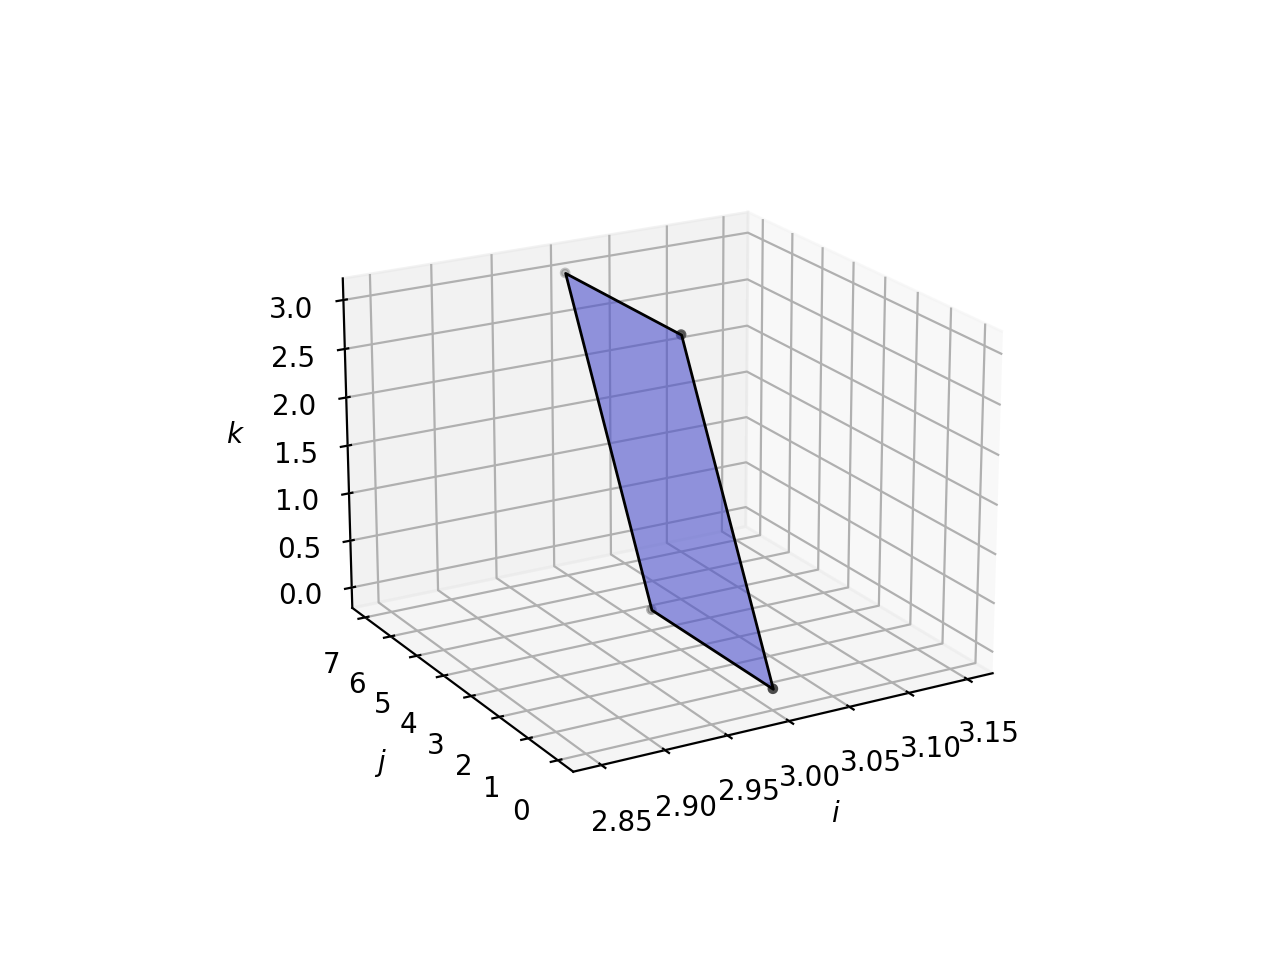


c0	[[ 1  0  0 -3]	{ [i, j, k] : -3 + i = 0 }
c1	 [ 0 -1  1  4]	{ [i, j, k] : 4 - j + k >= 0 }
c2	 [ 0  0  1  0]	{ [i, j, k] : k >= 0 }
c3	 [ 0  0 -1  3]	{ [i, j, k] : 3 - k >= 0 }
c4	 [ 0  1 -1  0]]	{ [i, j, k] : j - k >= 0 }



In [14]:
# consider the 2D facet {0}
s = '{ [i, j, k] : i = 3 and k >= -4 + j and 0 <= k <= j and k <= i }'

fp_str = '{[i,j,k]->[k,i]}'
fp = BasicMap(fp_str)
fd = BasicMap('{[i,j,k]->[k]}')

plot_3d_sets([BasicSet(s)])
print()

fl = FaceLattice(s)
fl.pretty_print_constraints()

#construct_rho_for_all_labelings(fl, fp, fd)
decomps = make_all_decompositions(fl, fp_str, fp)
for fp1 in decomps:
    print('fp1 = {}'.format(fp1))
    construct_rho_for_all_labelings(fl, fp1, fd)
    print()

This will be a scenario when we will try to split. Given $f_{p} = {[i,j,k] \rightarrow [i,k]}$ and a vertex $[3,3,3]$, we want o make the split at $j=3$, like this:

<IPython.core.display.Javascript object>


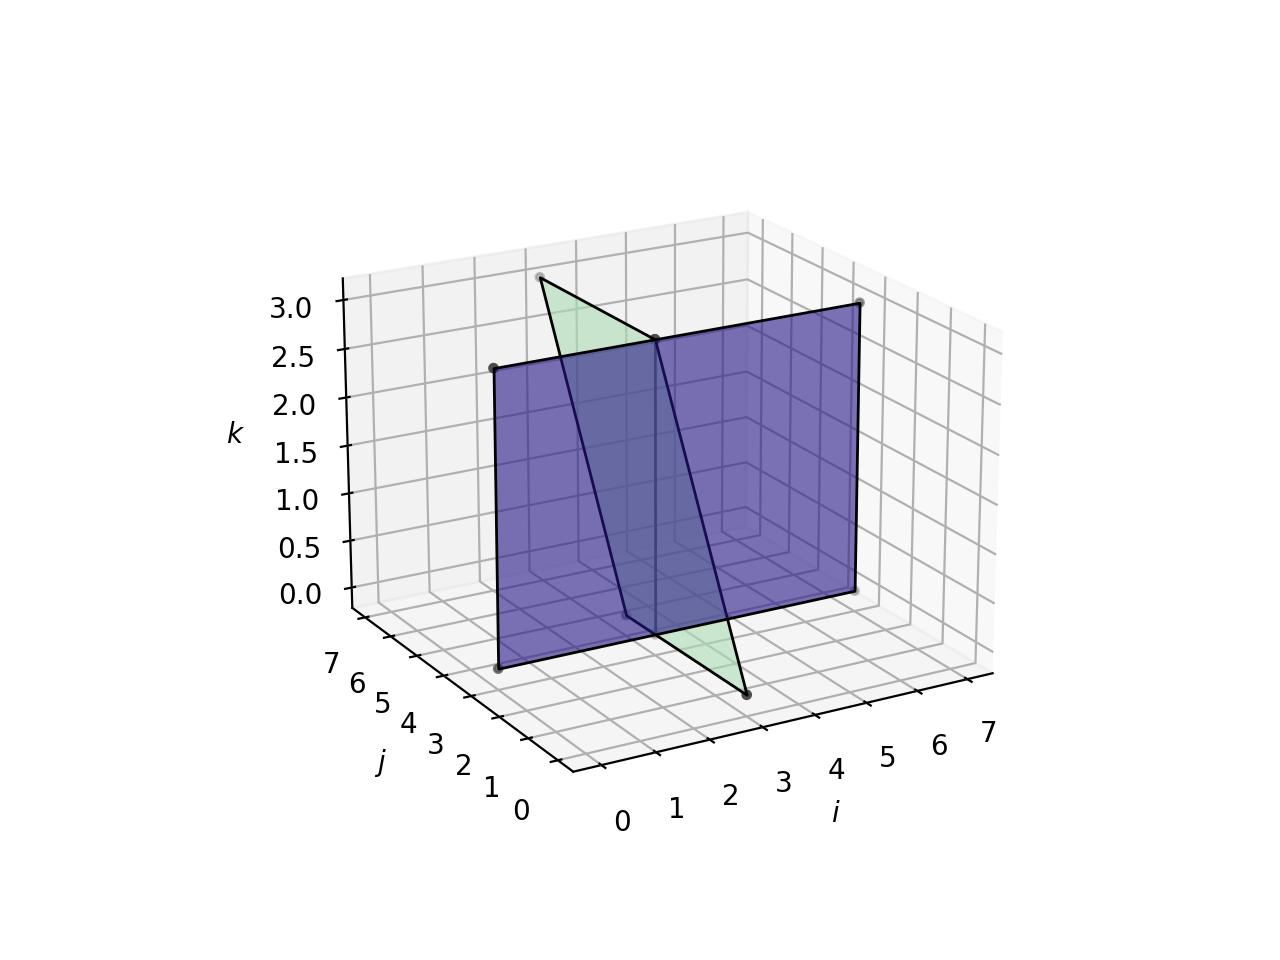

{ [i, j, k] : 0 <= i <= 7 and 0 <= j <= 7 and 0 <= k <= 3 }


In [15]:
domain = BasicSet('{[i,j,k] : 0<=k<=3 and 0<=i,j<=7 }')
split = BasicSet('{[i,j,k] : j=3 }').intersect(domain)
facet = BasicSet(s)
plot_3d_sets([facet, split, facet.intersect(split)])
print(domain)

In other words, we need to determine the orientation of the cut 